<a href="https://colab.research.google.com/github/sejeong-park/Energy_Consumption/blob/main/RNN%2CLSTM%2CGRU_Rolling_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

Import DATA

In [ ]:
data = pd.read_csv('household_power_consumption.txt',sep = ';',
                parse_dates={'dt':['Date','Time']},
                infer_datetime_format=True,
                low_memory=False, na_values=['nan','?'],
                index_col='dt')

In [ ]:
data.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2010-11-26 20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2010-11-26 21:01:00,0.934,0.0,239.70,3.8,0.0,0.0,0.0
2010-11-26 21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


In [ ]:
droping_list_all=[]
for j in range(0, 7):
    if not data.iloc[:, j].notnull().all():
        droping_list_all.append(j)
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [ ]:
for j in range(0,7):
    data.iloc[:,j]=data.iloc[:,j].fillna(data.iloc[:,j].mean())

In [ ]:
data.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [ ]:
from sklearn.metrics import r2_score
EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted
    
def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)

def mae(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Absolute Error """
    return np.mean(np.abs(_error(actual, predicted)))

def mse(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    return np.mean(np.square(_error(actual, predicted)))

def rmse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Error """
    return np.sqrt(mse(actual, predicted))

def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))

METRICS = {"mae":mae, "rmse":rmse, "mape":mape, "r2":r2_score, "mse":mse}

def evaluate(
    actual: np.ndarray,
    predicted: np.ndarray,
    metrics=(
        "mae",
        "rmse",
        "mape",
        "r2")):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results

resultsDict={}
predictionsDict={}

In [ ]:
data_resample = data.resample('D').sum() 
data_resample.rename(columns={"Global_active_power":"y"}, inplace=True)
data_resample = data_resample[['y']]
data_resample.tail()

,y
dt,
2010-11-22,2041.536
2010-11-23,1577.536
2010-11-24,1796.248
2010-11-25,1431.164
2010-11-26,1488.104


In [ ]:
import pandas as pd

def create_lags(df, days=7):
    # create lagged data for features
    for i in range(days):
        df["Lag_{lag}".format(lag=i+1)] = df['y'].shift(i+1)
    return df

def create_features(X, time_steps=1, n_features=7):
    # create 3d dataset for input
    cols, names = list(), list()
    for i in range(1, time_steps+1):
        cols.append(X.shift(-time_steps))
        names += [name + "_" + str(i) for name in X.columns]
        agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    agg.dropna(inplace=True)
    agg = agg.values.reshape(agg.shape[0], time_steps, n_features)
    return agg

def create_dataset(df, yhat):
    # yhat needs to be scaled
    preds = pd.DataFrame(yhat.flatten())
    temp = pd.concat([df.iloc[:,0], preds])
    temp.columns = ['y']
    date_idx = pd.date_range(start='2006-12-23', periods=temp.shape[0])
    temp.set_index(date_idx, inplace=True)
    return temp

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
chosen = data_resample.copy()
chosen = create_lags(chosen)
chosen.dropna(inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_x = scaler.fit(chosen.iloc[:,1:])
scaler_y = scaler.fit(chosen.loc[:,['y']])

x_scaled = scaler_x.transform(chosen.iloc[:,1:])
y_scaled = scaler_y.transform(chosen.loc[:,['y']])

scaled = np.hstack((x_scaled, y_scaled))
scaled = pd.DataFrame(scaled, index=chosen.index, columns=chosen.columns)
scaled.shape

(1435, 8)

In [ ]:
train = scaled[:1078]
val = scaled[1078:1256]
test = scaled[1256:]
x_train = train.drop(["y"],axis=1)
y_train = train["y"]
x_val = val.drop(["y"],axis=1)
y_val = val["y"]
x_test = test.drop(["y"],axis=1)
y_test = test["y"]

In [ ]:
x_train_np = create_features(x_train, 7, 7)
x_val_np = create_features(x_val, 7, 7)
x_test_np = create_features(x_test, 7, 7)
print(x_train_np.shape, x_val_np.shape, x_test_np.shape)
y_test = y_test[:x_test_np.shape[0]]
y_train = y_train[:x_train_np.shape[0]]
y_val = y_val[:x_val_np.shape[0]]
print(y_train.shape, y_val.shape, y_test.shape)

(1071, 7, 7) (171, 7, 7) (172, 7, 7)
(1071,) (171,) (172,)


In [ ]:
from keras import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU

def fit_model(m, units, x_train_np, x_val_np, verbose=False):
    model = Sequential()
    model.add(m (units = units, return_sequences = True, input_shape = [x_train_np.shape[1], x_train_np.shape[2]]))
    #model.add(Dropout(0.2))
    model.add(m (units = units))
    #model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    # Compile Model
    model.compile(loss='mse', optimizer='adam')
    # Fit Model
    history = model.fit(x_train_np, y_train, epochs=50, batch_size=70, 
                        validation_data=(x_val_np, y_val), verbose=False, shuffle=False)
    return model

In [ ]:
RNN_model = fit_model(SimpleRNN, 64, x_train_np, x_val_np)
LSTM_model = fit_model(LSTM, 64, x_train_np, x_val_np)
GRU_model = fit_model(GRU, 64, x_train_np, x_val_np)

In [ ]:
x_test_np

array([[[0.33085671, 0.3889701 , 0.25872943, ..., 0.16152682,
         0.22521472, 0.24579137],
        [0.33085671, 0.3889701 , 0.25872943, ..., 0.16152682,
         0.22521472, 0.24579137],
        [0.33085671, 0.3889701 , 0.25872943, ..., 0.16152682,
         0.22521472, 0.24579137],
        ...,
        [0.33085671, 0.3889701 , 0.25872943, ..., 0.16152682,
         0.22521472, 0.24579137],
        [0.33085671, 0.3889701 , 0.25872943, ..., 0.16152682,
         0.22521472, 0.24579137],
        [0.33085671, 0.3889701 , 0.25872943, ..., 0.16152682,
         0.22521472, 0.24579137]],

       [[0.16842122, 0.33085671, 0.3889701 , ..., 0.25289979,
         0.16152682, 0.28396175],
        [0.16842122, 0.33085671, 0.3889701 , ..., 0.25289979,
         0.16152682, 0.28396175],
        [0.16842122, 0.33085671, 0.3889701 , ..., 0.25289979,
         0.16152682, 0.28396175],
        ...,
        [0.16842122, 0.33085671, 0.3889701 , ..., 0.25289979,
         0.16152682, 0.28396175],
        [0.1

In [ ]:
RNN_preds = RNN_model.predict(x_test_np)
LSTM_preds = LSTM_model.predict(x_test_np)
GRU_preds = GRU_model.predict(x_test_np)

In [ ]:
rnn_preds = scaler_y.inverse_transform(RNN_preds)
y_test_actual = scaler_y.inverse_transform(pd.DataFrame(y_test))
resultsDict['RNN'] = evaluate(y_test_actual, rnn_preds)
evaluate(y_test_actual, rnn_preds)

{'mae': 237.66944041865253,
 'mape': 0.19824322053366464,
 'r2': 0.4727783744645154,
 'rmse': 319.75095022033634}

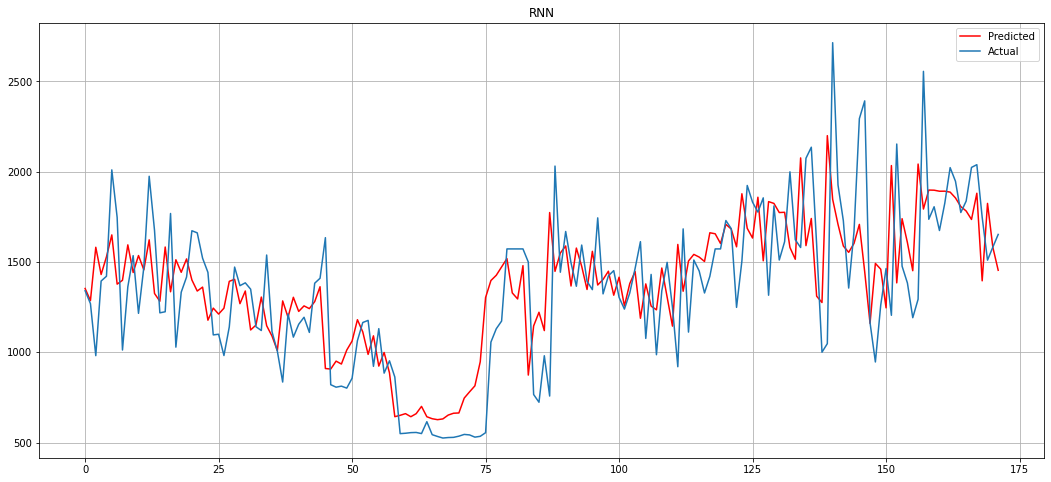

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(rnn_preds, "r-", label="Predicted")
plt.plot(y_test_actual, label="Actual")
plt.title('RNN')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('1 - RNN.jpg')

In [ ]:
lstm_preds = scaler_y.inverse_transform(LSTM_preds)
y_test_actual = scaler_y.inverse_transform(pd.DataFrame(y_test))
resultsDict['LSTM'] = evaluate(y_test_actual, lstm_preds)
evaluate(y_test_actual, lstm_preds)

{'mae': 244.62593532718097,
 'mape': 0.20605302694442965,
 'r2': 0.4346404379998917,
 'rmse': 331.1140480476518}

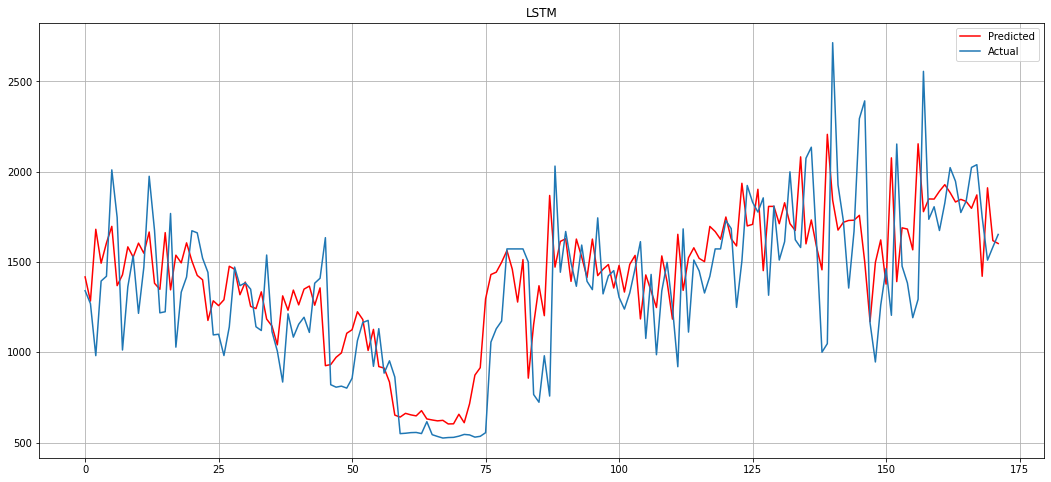

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(lstm_preds, "r-", label="Predicted")
plt.plot(y_test_actual, label="Actual")
plt.title('LSTM')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('2 - LSTM.jpg')

In [ ]:
gru_preds = scaler_y.inverse_transform(GRU_preds)
y_test_actual = scaler_y.inverse_transform(pd.DataFrame(y_test))
resultsDict['GRU'] = evaluate(y_test_actual, gru_preds)
evaluate(y_test_actual, gru_preds)

{'mae': 243.59709722932027,
 'mape': 0.20521639328418215,
 'r2': 0.4396286502806528,
 'rmse': 329.65008897544146}

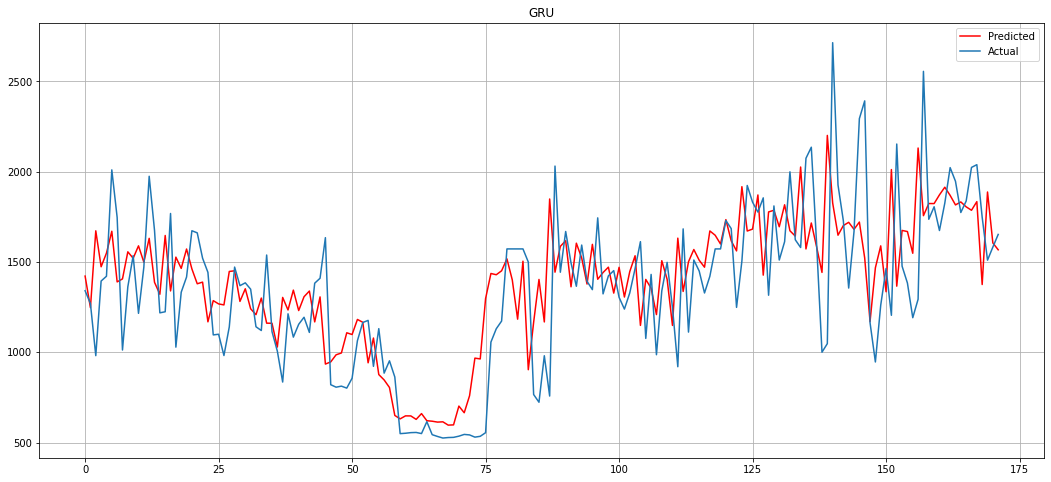

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(gru_preds, "r-", label="Predicted")
plt.plot(y_test_actual, label="Actual")
plt.title('GRU')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('3 - GRU.jpg')

In [ ]:
chosen = data_resample.copy()
chosen = create_lags(chosen)
chosen.dropna(inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_x = scaler.fit(chosen.iloc[:,1:])
scaler_y = scaler.fit(chosen.loc[:,['y']])

x_scaled = scaler_x.transform(chosen.iloc[:,1:])
y_scaled = scaler_y.transform(chosen.loc[:,['y']])

scaled = np.hstack((x_scaled, y_scaled))
scaled = pd.DataFrame(scaled, index=chosen.index, columns=chosen.columns)

train = scaled[:1078]
val = scaled[1078:1256]
test = scaled[1256:]

x_train = train.drop(["y"],axis=1)
y_train = train["y"]
x_val = val.drop(["y"],axis=1)
y_val = val["y"]
x_test = test.drop(["y"],axis=1)
y_test = test["y"]

In [ ]:
i = 0
def train_test_split(df, i=0):
    chosen = create_lags(df)
    chosen.dropna(inplace=True)
    x_scaled = scaler_x.transform(chosen.iloc[:,1:])
    y_scaled = scaler_y.transform(chosen.loc[:,['y']])

    scaled = np.hstack((x_scaled, y_scaled))
    scaled = pd.DataFrame(scaled, index=chosen.index, columns=chosen.columns)

    train = scaled[:1078+i]
    val = scaled[1078+i:1256+i]
    test = scaled[1256+i:]
    
    x_train = train.drop(["y"],axis=1)
    y_train = train["y"]
    x_val = val.drop(["y"],axis=1)
    y_val = val["y"]
    x_test = test.drop(["y"],axis=1)
    y_test = test["y"]

    n_features = len(x_train.columns)
    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = train_test_split(data_resample, i)
print(x_test.shape)

(179, 7)


In [ ]:
data_resample

,y,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7
dt,,,,,,,,
2006-12-23,4773.386,2341.338,1718.80723,2225.74800,1666.19400,2203.82600,3390.46000,1209.176
2006-12-24,2550.012,4773.386,2341.33800,1718.80723,2225.74800,1666.19400,2203.82600,3390.460
2006-12-25,2743.120,2550.012,4773.38600,2341.33800,1718.80723,2225.74800,1666.19400,2203.826
2006-12-26,3934.110,2743.120,2550.01200,4773.38600,2341.33800,1718.80723,2225.74800,1666.194
2006-12-27,1528.760,3934.110,2743.12000,2550.01200,4773.38600,2341.33800,1718.80723,2225.748
...,...,...,...,...,...,...,...,...
2010-11-22,2041.536,900.910,2197.00600,1570.40000,1652.15200,1582.03200,1509.74800,1747.382
2010-11-23,1577.536,2041.536,900.91000,2197.00600,1570.40000,1652.15200,1582.03200,1509.748
2010-11-24,1796.248,1577.536,2041.53600,900.91000,2197.00600,1570.40000,1652.15200,1582.032


In [ ]:
TIME_STEPS, N_FEATURES = 7, 7
rnn, lstm, gru = list(), list(), list()

for i in range(0, len(x_test), 30):
    temp = data_resample.copy()
    x_train, x_val, x_test, y_train, y_val, y_test = train_test_split(temp, i)
    
    x_train_np = create_features(x_train, TIME_STEPS, N_FEATURES)
    x_val_np = create_features(x_val, TIME_STEPS, N_FEATURES)
    x_test_np = create_features(x_test, TIME_STEPS, N_FEATURES)
    print(x_train_np.shape, x_val_np.shape, x_test_np.shape)
    y_test = y_test[:x_test_np.shape[0]]
    y_train = y_train[:x_train_np.shape[0]]
    y_val = y_val[:x_val_np.shape[0]]
    print(y_train.shape, y_val.shape, y_test.shape)
    
    if y_test.shape[0] != 0:
        RNN_model = fit_model(SimpleRNN, 64, x_train_np, x_val_np)
        LSTM_model = fit_model(LSTM, 64, x_train_np, x_val_np)
        GRU_model = fit_model(GRU, 64, x_train_np, x_val_np)

        RNN_preds = RNN_model.predict(x_test_np)
        yhat_actual = scaler_y.inverse_transform(RNN_preds)
        rnn.extend(yhat_actual.flatten()[:30])
        LSTM_preds = LSTM_model.predict(x_test_np)
        yhat_actual = scaler_y.inverse_transform(LSTM_preds)
        lstm.extend(yhat_actual.flatten()[:30])
        GRU_preds = GRU_model.predict(x_test_np)
        yhat_actual = scaler_y.inverse_transform(GRU_preds)
        gru.extend(yhat_actual.flatten()[:30])

(1071, 7, 7) (171, 7, 7) (165, 7, 7)
(1071,) (171,) (165,)
(1101, 7, 7) (171, 7, 7) (135, 7, 7)
(1101,) (171,) (135,)
(1131, 7, 7) (171, 7, 7) (105, 7, 7)
(1131,) (171,) (105,)
(1161, 7, 7) (171, 7, 7) (75, 7, 7)
(1161,) (171,) (75,)
(1191, 7, 7) (171, 7, 7) (45, 7, 7)
(1191,) (171,) (45,)
(1221, 7, 7) (171, 7, 7) (15, 7, 7)
(1221,) (171,) (15,)


In [ ]:
len(rnn)

165

In [ ]:
y_test_actual

array([[1340.462     ],
       [1268.964     ],
       [ 980.898     ],
       [1394.186     ],
       [1420.554     ],
       [2009.644     ],
       [1746.792     ],
       [1012.082     ],
       [1362.034     ],
       [1534.682     ],
       [1215.19      ],
       [1470.672     ],
       [1974.19961504],
       [1674.356     ],
       [1217.984     ],
       [1223.966     ],
       [1768.092     ],
       [1028.018     ],
       [1332.316     ],
       [1416.22      ],
       [1672.55      ],
       [1660.89      ],
       [1520.588     ],
       [1442.064     ],
       [1095.78      ],
       [1099.438     ],
       [ 981.62      ],
       [1139.964     ],
       [1471.34      ],
       [1368.38761504],
       [1384.136     ],
       [1349.002     ],
       [1140.928     ],
       [1120.074     ],
       [1538.088     ],
       [1113.99      ],
       [1005.934     ],
       [ 834.788     ],
       [1212.652     ],
       [1083.478     ],
       [1154.504     ],
       [1193.572

In [ ]:
resultsDict['RNN Rolling'] = evaluate(y_test_actual[7:], rnn)
evaluate(y_test_actual[7:], rnn)

{'mae': 467.03064547834543,
 'mape': 0.4424526359435803,
 'r2': 0.43254766263285194,
 'rmse': 585.1330173135334}

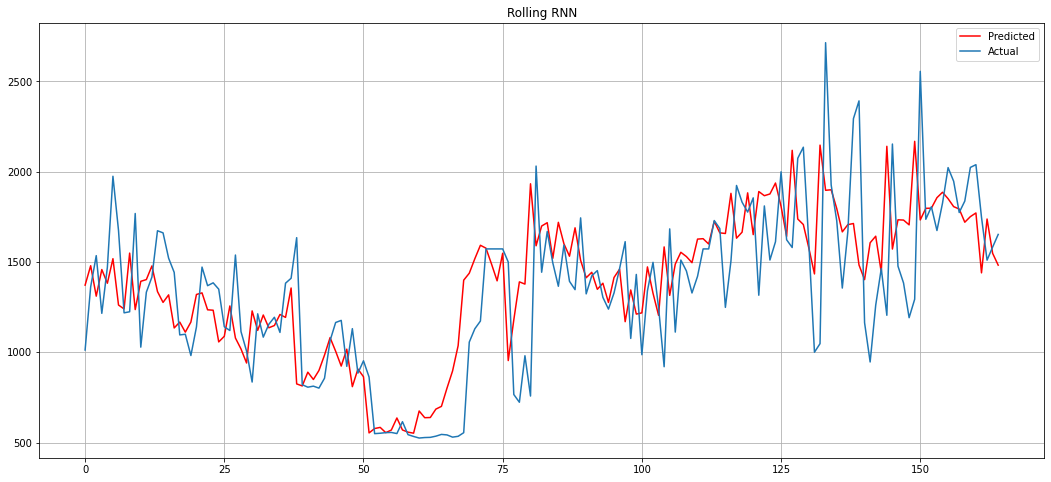

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(rnn, "r-", label="Predicted")
plt.plot(y_test_actual[7:], label="Actual")
plt.legend()
plt.title('Rolling RNN')
plt.grid(True)
plt.show()
plt.savefig('4 - RNN (Rolling).jpg')

In [ ]:
resultsDict['LSTM Rolling'] = evaluate(y_test_actual[7:], lstm)
evaluate(y_test_actual[7:], lstm)

{'mae': 448.7387428581136,
 'mape': 0.4286686656591761,
 'r2': 0.46668724179941157,
 'rmse': 565.5076529787176}

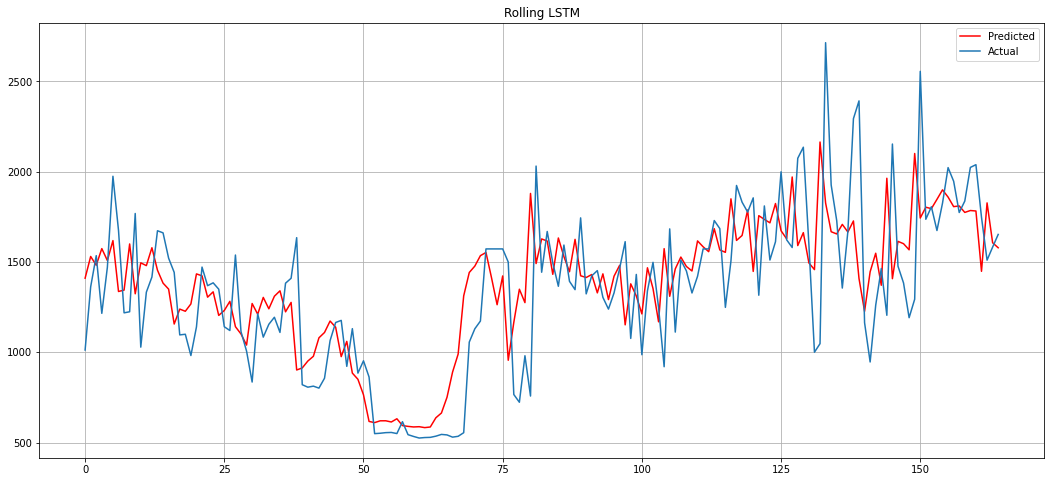

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(lstm, "r-", label="Predicted")
plt.plot(y_test_actual[7:], label="Actual")
plt.legend()
plt.title('Rolling LSTM')
plt.grid(True)
plt.show()
plt.savefig('5 - LSTM (Rolling).jpg')

In [ ]:
resultsDict['GRU Rolling'] = evaluate(y_test_actual[7:], gru)
evaluate(y_test_actual[7:], gru)

{'mae': 448.9388553208773,
 'mape': 0.4283183025935387,
 'r2': 0.46077587572157575,
 'rmse': 565.2075698620582}

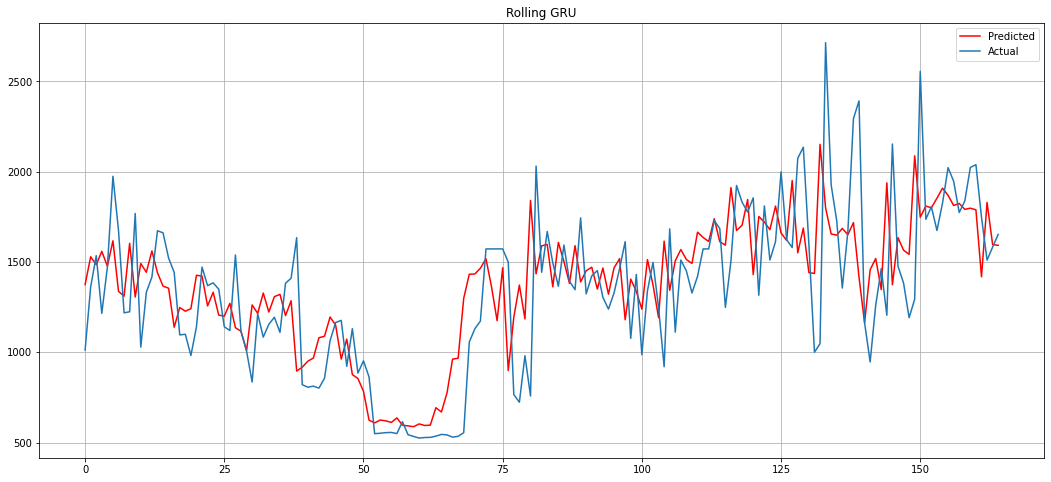

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(gru, "r-", label="Predicted")
plt.plot(y_test_actual[7:], label="Actual")
plt.legend()
plt.title('Rolling GRU')
plt.grid(True)
plt.show()
plt.savefig('6 - GRU (Rolling).jpg')

In [ ]:
resultsDict

{'GRU': {'mae': 243.59709722932027,
  'mape': 0.20521639328418215,
  'r2': 0.4396286502806528,
  'rmse': 329.65008897544146},
 'GRU Rolling': {'mae': 448.9388553208773,
  'mape': 0.4283183025935387,
  'r2': 0.46077587572157575,
  'rmse': 565.2075698620582},
 'LSTM': {'mae': 244.62593532718097,
  'mape': 0.20605302694442965,
  'r2': 0.4346404379998917,
  'rmse': 331.1140480476518},
 'LSTM Rolling': {'mae': 448.7387428581136,
  'mape': 0.4286686656591761,
  'r2': 0.46668724179941157,
  'rmse': 565.5076529787176},
 'RNN': {'mae': 237.66944041865253,
  'mape': 0.19824322053366464,
  'r2': 0.4727783744645154,
  'rmse': 319.75095022033634},
 'RNN Rolling': {'mae': 467.03064547834543,
  'mape': 0.4424526359435803,
  'r2': 0.43254766263285194,
  'rmse': 585.1330173135334}}

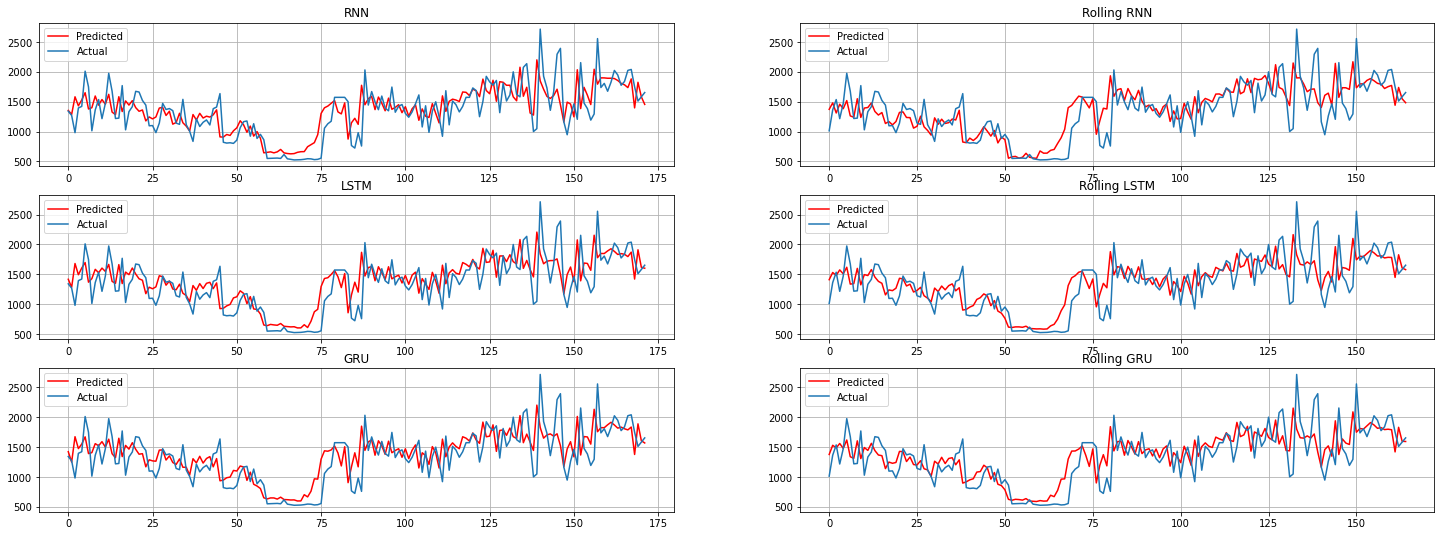

<Figure size 432x288 with 0 Axes>

In [ ]:
fig,a =  plt.subplots(3,2, figsize=(25,9))

a[0][0].plot(rnn_preds, "r-", label="Predicted")
a[0][0].plot(y_test_actual, label="Actual")
a[0][0].legend()
a[0][0].grid(True)
a[0][0].set_title('RNN')
a[0][1].plot(rnn, "r-", label="Predicted")
a[0][1].plot(y_test_actual[7:], label="Actual")
a[0][1].legend()
a[0][1].grid(True)
a[0][1].set_title('Rolling RNN')
a[1][0].plot(lstm_preds, "r-", label="Predicted")
a[1][0].plot(y_test_actual, label="Actual")
a[1][0].legend()
a[1][0].grid(True)
a[1][0].set_title('LSTM')
a[1][1].plot(lstm, "r-", label="Predicted")
a[1][1].plot(y_test_actual[7:], label="Actual")
a[1][1].legend()
a[1][1].grid(True)
a[1][1].set_title('Rolling LSTM')
a[2][0].plot(gru_preds, "r-", label="Predicted")
a[2][0].plot(y_test_actual, label="Actual")
a[2][0].legend()
a[2][0].grid(True)
a[2][0].set_title('GRU')
a[2][1].plot(gru, "r-", label="Predicted")
a[2][1].plot(y_test_actual[7:], label="Actual")
a[2][1].legend()
a[2][1].grid(True)
a[2][1].set_title('Rolling GRU')
plt.show()
plt.savefig('Summary.jpg')

https://www.kaggle.com/mingboi/rolling-rnn-lstm-gru-lstnet-tpa-lstm